# Biomarker Discovery

#### We will leverage Subgraph Detection, one of the modules included in BioNeuralNet, to identify densely connected omics from a larger Multi-Omics Network.
- These densely connected omics represent biologically meaningful **modules** and are highly correlated to their respective phenotype.
- To demonstrate this, we will use two Cancer Datasets from The Cancer Genome Atlas (TCGA):
    - BRCA
    - PAAD
- We will also leverage BioNeuralNet visualization tools to explore the discovered omic modules.

In [1]:
import bioneuralnet as bnn

tgca_brca = bnn.datasets.DatasetLoader("brca")
display(tgca_brca.shape)

brca_dna_meth = tgca_brca.data["meth"]
brca_rna = tgca_brca.data["rna"]
brca_mirna = tgca_brca.data["mirna"]
brca_clinical = tgca_brca.data["clinical"]
brca_target = tgca_brca.data["pam50"]

tgca_paad = bnn.datasets.DatasetLoader("paad")
display(tgca_paad.shape)

paad_dna_meth = tgca_paad.data["meth"]
paad_rna = tgca_paad.data["rna"]
paad_cnv_del = tgca_paad.data["cnv_del"]
paad_cnv_amp = tgca_paad.data["cnv_amp"]
paad_clinical = tgca_paad.data["clinical"]
paad_target = tgca_paad.data["target"]

{'mirna': (769, 503),
 'pam50': (769, 1),
 'clinical': (769, 118),
 'rna': (769, 1687),
 'meth': (769, 1605)}

{'cnv_amp': (177, 967),
 'cnv_del': (177, 1600),
 'target': (177, 1),
 'clinical': (177, 19),
 'rna': (177, 1910),
 'meth': (177, 1150)}

In [3]:
import bioneuralnet as bnn

SEED = 118
bnn.utils.set_seed(SEED)

2025-11-11 16:51:38,923 - bioneuralnet.utils.data - INFO - Setting global seed for reproducibility to: 118
2025-11-11 16:51:38,927 - bioneuralnet.utils.data - INFO - CUDA available. Applying seed to all GPU operations
2025-11-11 16:51:38,928 - bioneuralnet.utils.data - INFO - Seed setting complete


## Feature Selection

This script implements a robust feature selection pipeline by combining two different methods. (one linear and one non-linear)

### 1. Two-Method Selection

Features are selected from three omics datasets respective to the BRCA dataset (DNA methylation, RNA, miRNA). 

- **ANOVA F-test (`top_anova_f_features`):** A statistical test that identifies features with strong **linear** relationships to the target variable (Pam 50 classification).
- **Random Forest (`select_top_randomforest`):** A machine learning model that identifies feature importance based on complex, **non-linear** relationships.

### 2. Intersection
After identifying each set indepenterly, we then find the **intersection** (overlap) of the feature lists generated by both methods for each omic type.

**Rationale:** This dual approach creates a high-confidence feature set. By selecting only features deemed important by *both* a linear *and* a non-linear model, the process filters out noise and increases the reliability of the selected features.

This final feature set is then used to generate a correlation graph (`brca_correlation_graph`).

In [ ]:
import pandas as pd
import bioneuralnet as bnn

dna_meth_af = bnn.utils.top_anova_f_features(brca_dna_meth, brca_target, max_features=200)
rna_af = bnn.utils.top_anova_f_features(brca_rna, brca_target, max_features=200)
mirna_af = bnn.utils.top_anova_f_features(brca_mirna, brca_target, max_features=50)

dna_meth_rf = bnn.utils.select_top_randomforest(brca_dna_meth, brca_target, top_k=200)
rna_rf = bnn.utils.select_top_randomforest(brca_rna, brca_target, top_k=200)
mirna_rf = bnn.utils.select_top_randomforest(brca_mirna, brca_target, top_k=50)

dna_meth_overlap_features = list(set(dna_meth_af).intersection(dna_meth_rf))
print(f"Number of overlapping features DNA_Methylation: {len(dna_meth_overlap_features)}")

rna_overlap_features = list(set(rna_af).intersection(rna_rf))
print(f"Number of overlapping features for RNA: {len(rna_overlap_features)}")

mirna_overlap_features = list(set(mirna_af).intersection(mirna_rf))
print(f"Number of overlapping for miRNA: {len(mirna_overlap_features)}")

# We subset the omics data to the set of overlapping features.
selected_dna_meth = brca_dna_meth[dna_meth_overlap_features]
selected_rna = brca_rna[rna_overlap_features]
selected_mirna = mirna_af[mirna_overlap_features]

brca_selected = pd.concat([selected_dna_meth, selected_rna, selected_mirna], axis=1)

#Lastly, we build a  correlation graph with the subset of features.
brca_correlation_graph = bnn.utils.gen_correlation_graph(brca_selected, k=10)
print(brca_correlation_graph.shape)

2025-11-11 16:51:39,206 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-11 16:51:39,207 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-11 16:51:39,207 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-11 16:51:39,220 - bioneuralnet.utils.preprocess - INFO - Selected 200 features by ANOVA (task=classification), 1605 significant, 0 padded
2025-11-11 16:51:39,493 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-11 16:51:39,494 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-11 16:51:39,494 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-11 16:51:39,507 - bioneuralnet.utils.preprocess - INFO - Selected 200 features by ANOVA (task=classification), 1687 significant, 0 padded
2025-11-11 16:51:39,607 - bioneuralnet.utils.preproces

Number of overlapping features DNA_Methylation: 92
Number of overlapping features for RNA: 90
Number of overlapping for miRNA: 41
(223, 223)


In [5]:
import networkx as nx

# We turn the correlation graph adjency matrix into a network-x graph object
G_brca_network = nx.from_pandas_adjacency(brca_correlation_graph)

hybrid_brca = bnn.clustering.CorrelatedLouvain(
    G=G_brca_network,
    B=brca_selected,
    Y=brca_target,
)

brca_hybrid_result = hybrid_brca.run(as_dfs=True)
print(f"Cluster founds: {len(brca_hybrid_result)}")

2025-11-11 16:51:44,212 - bioneuralnet.clustering.correlated_louvain - INFO - Initialized CorrelatedLouvain with k3 = 0.2, k4 = 0.8, 
2025-11-11 16:51:44,212 - bioneuralnet.clustering.correlated_louvain - INFO - Original omics data shape: (769, 223)
2025-11-11 16:51:44,213 - bioneuralnet.clustering.correlated_louvain - INFO - Original graph has 223 nodes.
2025-11-11 16:51:44,213 - bioneuralnet.clustering.correlated_louvain - INFO - Final omics data shape: (769, 223)
2025-11-11 16:51:44,213 - bioneuralnet.clustering.correlated_louvain - INFO - Graph has 223 nodes and 1759 edges.
2025-11-11 16:51:44,214 - bioneuralnet.clustering.correlated_louvain - INFO - Initialized Correlated Louvain. device=cpu
2025-11-11 16:51:44,214 - bioneuralnet.clustering.correlated_louvain - INFO - Running standard community detection...
2025-11-11 16:51:44,226 - bioneuralnet.clustering.correlated_louvain - INFO - Computing community correlation for 50 nodes...
2025-11-11 16:51:44,227 - bioneuralnet.clustering.

Clusters with >2 nodes: 5
Returning 5 clusters after filtering
Cluster founds: 5


In [54]:
from bioneuralnet.metrics import louvain_to_adjacency

# we provide Function to take the output and process it back into an adjency matrix
brca_cluster1 = louvain_to_adjacency(brca_hybrid_result[0])
brca_cluster3 = louvain_to_adjacency(brca_hybrid_result[2])
brca_cluster4 = louvain_to_adjacency(brca_hybrid_result[3])

print(brca_cluster1.shape)
print(brca_cluster3.shape)
print(brca_cluster4.shape)

(50, 50)
(75, 75)
(15, 15)


## Biomarker Results from the BRCA Subgraphs

The clustering output from the Correlated Louvain algorithm confirms the successful isolation of feature modules strongly relevant to Breast Cancer (BRCA).

### Key Strengths

- **Cluster 3 (Hormone Signaling)**: This 75-node module represents the core hormone signaling pathway. Degree analysis confirms the top hubs are **`ESR1_2099`** (Estrogen Receptor), **`FOXA1_3169`**, and **`MLPH_79083`**. Based on the sources below, these are known drivers of breast cancer.
- **Cluster 4 (Proliferation):** This cluster is a proliferation signature, confirmed by graphs density, where its several edges have a a perfect `1.0` correlation. The hub features are **`MCM10_55388`**, **`TTK_7272`**, and **`CENPA_1058`**, representing the core Omics.

### Sources

The omics features identified in these modules are well-established drivers of BRCA, and their relevance is confirmed by comprehensive genomic studies.

1. [https://www.biorxiv.org/content/10.101/2024.08.30.610515v2.full](https://www.google.com/search?q=https://www.biorxiv.org/content/10.101/2024.08.30.610515v2.full)
2. [https://www.oncotarget.com/article/12010/text/](https://www.oncotarget.com/article/12010/text/)
3. [https://pmc.ncbi.nlm.nih.gov/articles/PMC4959370/](https://pmc.ncbi.nlm.nih.gov/articles/PMC4959370/)

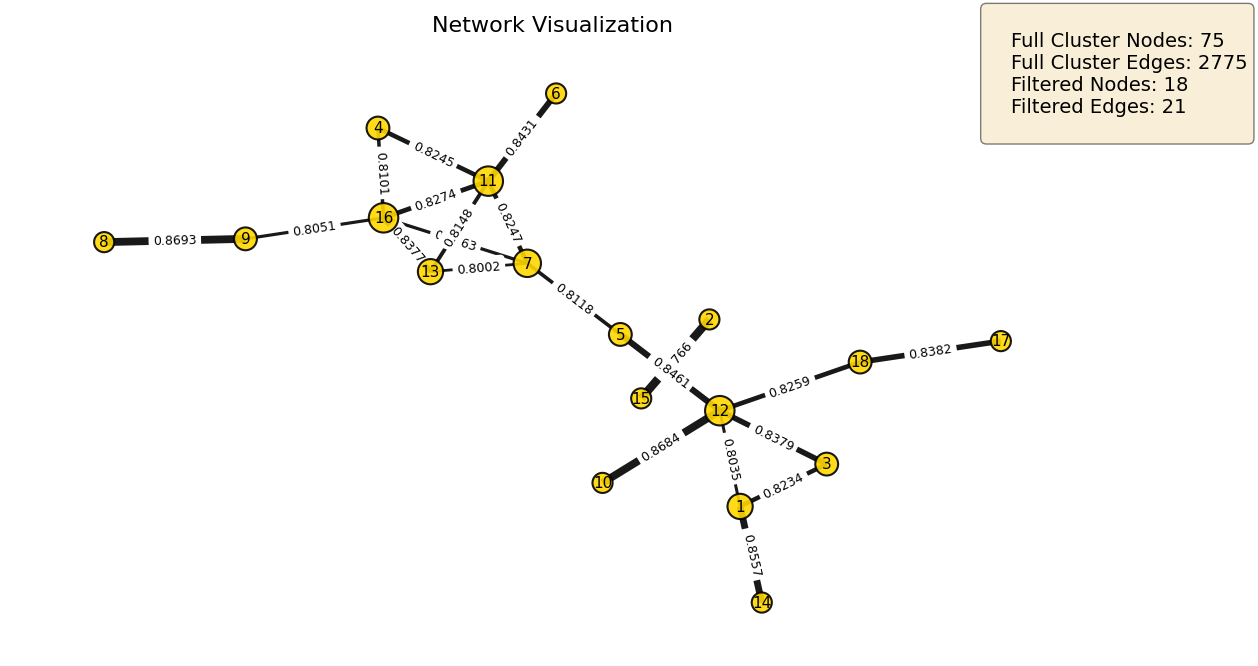

                Omic  Degree
Index                       
16        MLPH_79083       5
12         ESR1_2099       5
11        FOXA1_3169       5
7         AGR2_10551       4
1        THSD4_79875       3
13      PRR15_222171       3
9          TFF3_7033       2
18        GATA3_2625       2
5        AGR3_155465       2
4      SLC44A4_80736       2


In [36]:
brca_mapping_large_cluster = bnn.plot_network(
    brca_cluster3,
    weight_threshold=.8,
    show_labels=True,
    show_edge_weights=True
)

print(brca_mapping_large_cluster.head(10))

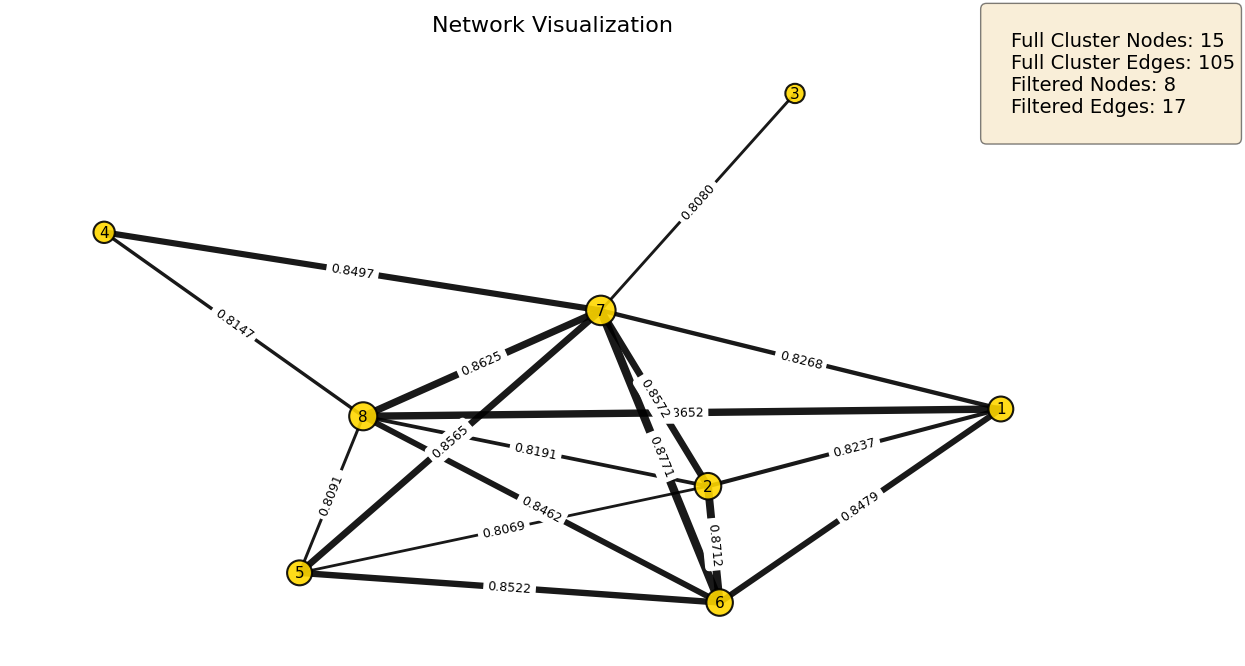

                Omic  Degree
Index                       
7        MCM10_55388       7
8           TTK_7272       6
2         AURKA_6790       5
6         CENPA_1058       5
1      FAM54A_113115       4


In [8]:
brca_small_cluster = bnn.plot_network(
    brca_cluster4,
    weight_threshold=.8,
    show_labels=True,
    show_edge_weights=True
)

print(brca_small_cluster.head())

---

## Biomarker Results from the PAAD Subgraphs

The clustering output from the Correlated Louvain algorithm confirms the successful isolation of feature modules strongly relevant to Pancreatic Adenocarcinoma (PAAD).

### Key Strengths

- **Cluster 3 (Proliferation):** This module represents a core proliferation pathway. Degree analysis identifies the hubs as **`rna_ANLN`**, **`rna_TOP2A`**, **`rna_CDCA5`**, and **`rna_AURKA`**. Based on the sources, these are all known drivers of rapid cell division.

- **Cluster 9 (Amplification):** This 28-node cluster shows a group of genes amplified together, confirmed by several perfect `1.0` correlations. The key driver is **`amp_TERC`**, which cancer cells copy to gain a form of immortality, allowing for endless division.

### Sources

The omics features identified in these modules are well-established drivers of PAAD, and their relevance is confirmed by comprehensive genomic studies.

1. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6388914/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6388914/)
2. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9189053/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9189053/)
3. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3839213/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3839213/)
4. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5641195/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5641195/)
5. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4606179/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4606179/)
```

In [9]:
dna_meth_af = bnn.utils.top_anova_f_features(paad_dna_meth, paad_target, max_features=200)
rna_af = bnn.utils.top_anova_f_features(paad_rna, paad_target, max_features=200)
cnv_del_af = bnn.utils.top_anova_f_features(paad_cnv_del, paad_target, max_features=200)
cnv_amp_af = bnn.utils.top_anova_f_features(paad_cnv_amp, paad_target, max_features=200)

dna_meth_rf = bnn.utils.select_top_randomforest(paad_dna_meth, paad_target, top_k=200)
rna_rf = bnn.utils.select_top_randomforest(paad_rna, paad_target, top_k=200)
cnv_del_rf = bnn.utils.select_top_randomforest(paad_cnv_del, paad_target, top_k=200)
cnv_amp_rf = bnn.utils.select_top_randomforest(paad_cnv_amp, paad_target, top_k=200)

dna_meth_overlap_features = list(set(dna_meth_af).intersection(dna_meth_rf))
print(f"Number of overlapping features DNA_Methylation: {len(dna_meth_overlap_features)}")

rna_overlap_features = list(set(rna_af).intersection(rna_rf))
print(f"Number of overlapping features for RNA: {len(rna_overlap_features)}")

cnv_del_overlap_features = list(set(cnv_del_af).intersection(cnv_del_rf))
print(f"Number of overlapping for CNV Deletion: {len(cnv_del_overlap_features)}")

cnv_amp_overlap_features = list(set(cnv_amp_af).intersection(cnv_amp_rf))
print(f"Number of overlapping for CNV Amplification: {len(cnv_amp_overlap_features)}")

selected_dna_meth = paad_dna_meth[dna_meth_overlap_features]
selected_rna = paad_rna[rna_overlap_features]
selected_cnv_del = paad_cnv_del[cnv_del_overlap_features]
selected_cnv_amp = paad_cnv_amp[cnv_amp_overlap_features]

paad_selected = pd.concat([selected_dna_meth, selected_rna, selected_cnv_del, selected_cnv_amp], axis=1)

paad_correlation_graph = bnn.utils.gen_correlation_graph(paad_selected, k=10)
print(paad_correlation_graph.shape)

2025-11-11 16:51:44,660 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-11 16:51:44,660 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-11 16:51:44,661 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-11 16:51:44,665 - bioneuralnet.utils.preprocess - INFO - Selected 200 features by ANOVA (task=classification), 876 significant, 0 padded
2025-11-11 16:51:44,894 - bioneuralnet.utils.preprocess - INFO - [Inf]: Replaced 0 infinite values
2025-11-11 16:51:44,894 - bioneuralnet.utils.preprocess - INFO - [NaN]: Replaced 0 NaNs after median imputation
2025-11-11 16:51:44,894 - bioneuralnet.utils.preprocess - INFO - [Zero-Var]: 0 columns dropped due to zero variance
2025-11-11 16:51:44,901 - bioneuralnet.utils.preprocess - INFO - Selected 200 features by ANOVA (task=classification), 1816 significant, 0 padded
2025-11-11 16:51:45,071 - bioneuralnet.utils.preprocess

Number of overlapping features DNA_Methylation: 60
Number of overlapping features for RNA: 61
Number of overlapping for CNV Deletion: 41
Number of overlapping for CNV Amplification: 58
(220, 220)


In [44]:
import networkx as nx

# We turn the correlation graph adjency matrix into a network-x graph object
G_paad_network = nx.from_pandas_adjacency(paad_correlation_graph)

hybrid_paad = bnn.clustering.CorrelatedLouvain(
    G=G_paad_network,
    B=paad_selected,
    Y=paad_target,
)

paad_hybrid_result = hybrid_paad.run(as_dfs=True)
print(f"Cluster founds: {len(paad_hybrid_result)}")

2025-11-12 19:10:43,903 - bioneuralnet.clustering.correlated_louvain - INFO - Initialized CorrelatedLouvain with k3 = 0.2, k4 = 0.8, 
2025-11-12 19:10:43,903 - bioneuralnet.clustering.correlated_louvain - INFO - Original omics data shape: (177, 220)
2025-11-12 19:10:43,904 - bioneuralnet.clustering.correlated_louvain - INFO - Original graph has 220 nodes.
2025-11-12 19:10:43,904 - bioneuralnet.clustering.correlated_louvain - INFO - Final omics data shape: (177, 220)
2025-11-12 19:10:43,904 - bioneuralnet.clustering.correlated_louvain - INFO - Graph has 220 nodes and 1602 edges.
2025-11-12 19:10:43,905 - bioneuralnet.clustering.correlated_louvain - INFO - Initialized Correlated Louvain. device=cpu
2025-11-12 19:10:43,905 - bioneuralnet.clustering.correlated_louvain - INFO - Running standard community detection...
2025-11-12 19:10:43,918 - bioneuralnet.clustering.correlated_louvain - INFO - Computing community correlation for 22 nodes...
2025-11-12 19:10:43,920 - bioneuralnet.clustering.

Clusters with >2 nodes: 9
Returning 9 clusters after filtering
Cluster founds: 9


In [45]:
paad_cluster1 = louvain_to_adjacency(paad_hybrid_result[0])
paad_cluster3 = louvain_to_adjacency(paad_hybrid_result[2])
paad_cluster9 = louvain_to_adjacency(paad_hybrid_result[8])

print(paad_cluster1.shape)
print(paad_cluster3.shape)
print(paad_cluster9.shape)

(22, 22)
(48, 48)
(28, 28)


In [52]:
paad_cluster9.iloc[:5,:5]

,amp_AADACL2,amp_AMOTL2,amp_TERC,amp_GPR160,amp_HTR3E
amp_AADACL2,0.000000,0.830620,0.880124,0.880124,0.910780
amp_AMOTL2,0.830620,0.000000,0.817600,0.817600,0.840364
amp_TERC,0.880124,0.817600,0.000000,1.000000,0.920729
amp_GPR160,0.880124,0.817600,1.000000,0.000000,0.920729
amp_HTR3E,0.910780,0.840364,0.920729,0.920729,0.000000


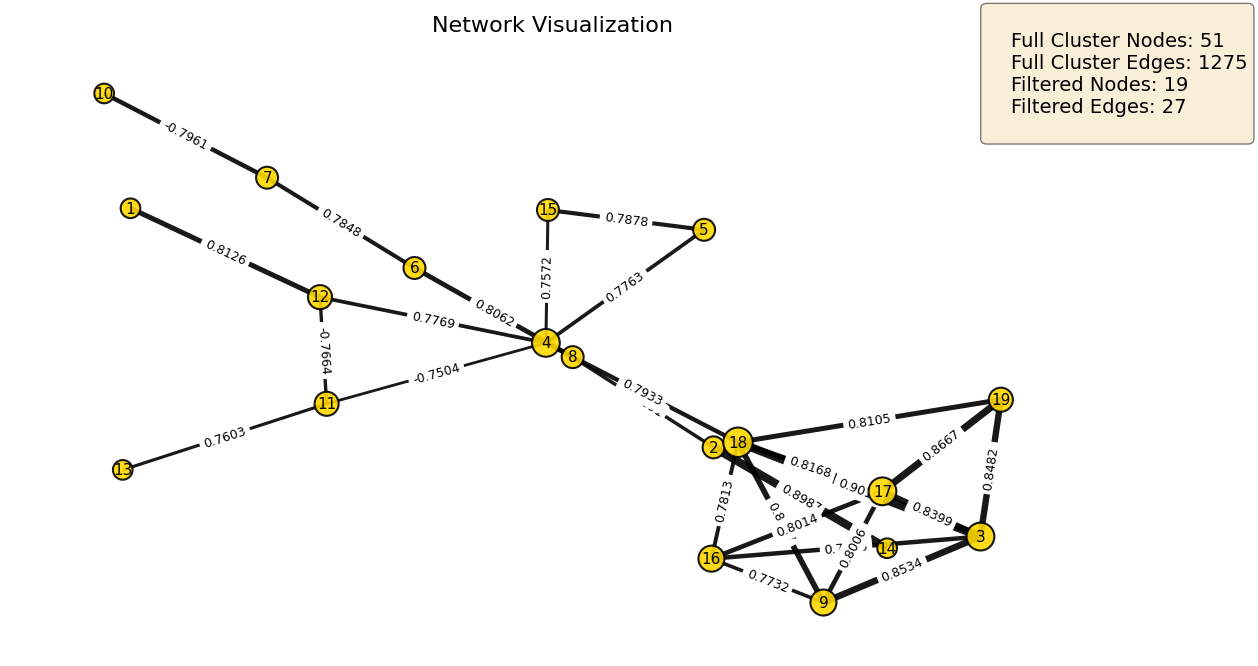

Omics from cluster 3 (PAAD):

               Omic  Degree
Index                      
18         rna_ANLN       6
3         rna_TOP2A       5
4           rna_MET       5
17        rna_CDCA5       5
16     rna_C11orf82       4
9       rna_FAM111B       4
19        rna_AURKA       3
11     rna_SLC26A11       3
12        rna_LAMB3       3
5         rna_ITGA2       2


In [37]:
paad_omics_cluster3 = bnn.plot_network(
    paad_cluster3,
    weight_threshold=.75,
    show_labels=True,
    show_edge_weights=True
)

print("Omics from cluster 3 (PAAD):\n")
print(paad_omics_cluster3.head(10))

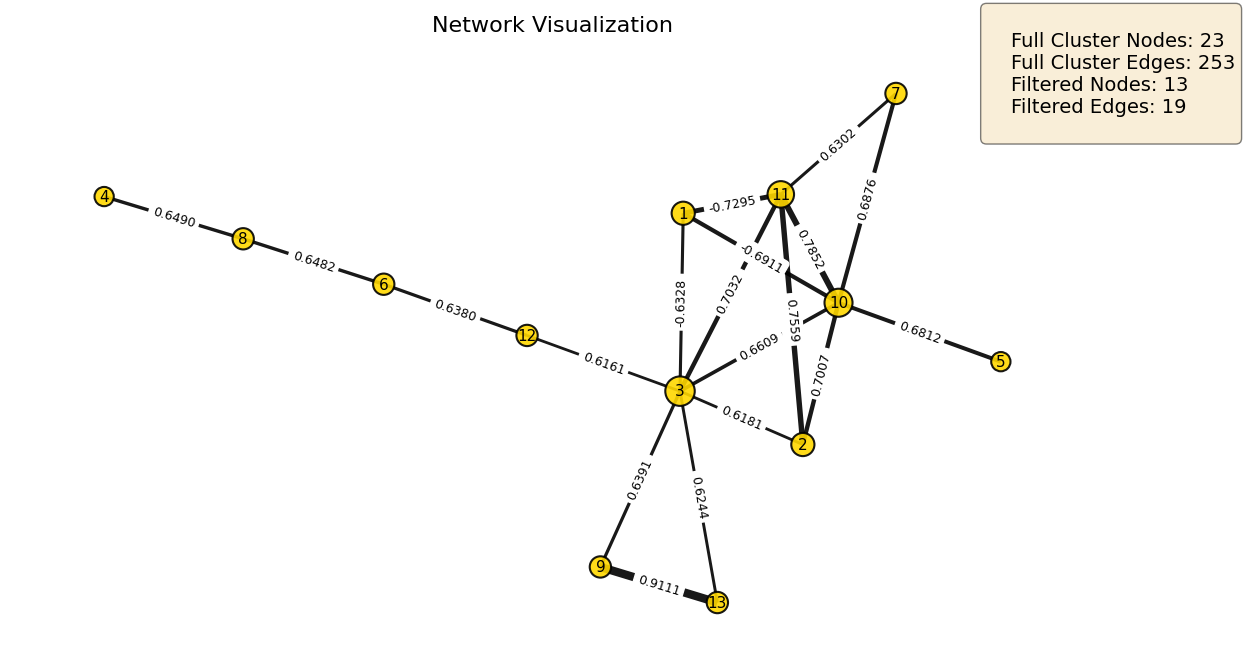

Omics from cluster 1 (PAAD):

                     Omic  Degree
Index                            
3       meth_RP11_104C4.4       7
10        meth_AC005229.7       6
11     meth_RP11_528A10.1       5
1       meth_CTD_2526A2.2       3
2             meth_BMS1P3       3


In [32]:
paad_omics_cluster1 = bnn.plot_network(
    paad_cluster1,
    weight_threshold=.6,
    show_labels=True,
    show_edge_weights=True
)

print("Omics from cluster 1 (PAAD):\n")
print(paad_omics_cluster1.head())


## Biomarker Results from the PAAD Subgraphs

The clustering output from the Correlated Louvain algorithm confirms the successful isolation of feature modules strongly relevant to Pancreatic Adenocarcinoma (PAAD).

### Key Strengths

**Modular Relevance:** The algorithm partitioned the 220-node network into 9 distinct functional modules. After looking at the results, two cluster stood out.

**Biological Cohesion:** The results identify biologically relevant groups. Network visulization and degree analysis reveal the specific hub features for the two most significant clusters:

  - **Cluster 3**: This module represents a core proliferation and cell cycle pathway. Degree analysis identifies the hubs as **`rna_ANLN`**, **`rna_TOP2A`**, **`rna_CDCA5`**, and **`rna_AURKA`**, all of which are critical for mitotic progression. This module is also co-regulated with the key invasion and metastasis driver, **`rna_MET`**.
  -**Cluster 9**: This 28-node cluster is a classic **co-amplification event** on the 3q chromosomal arm, confirmed by the perfect `1.0` correlations in the matrix. The key driver in this amplicon is **`amp_TERC`** (Telomerase RNA Component), which cancer cells amplify to ensure telomere maintenance, a critical step for sustained proliferation.

**Network Value:** The output integrates multiple omics types (`rna_`, `amp_`) and quantifies their correlation. This allows for direct inspection of how features related to RNA expression (Cluster 3) and DNA amplification (Cluster 9) form distinct, functional modules that drive the disease.


## Sources & Omics Validation

The omics features identified in these modules are well-established drivers of PAAD, and their relevance is confirmed by comprehensive genomic studies.

The hubs from your clusters are directly validated by the following research:

  * **Cluster 3 Hubs:** The genes **`rna_ANLN`**, **`rna_AURKA`**, and **`rna_TOP2A`** are all known to be overexpressed in PAAD and are strongly associated with high proliferation and poor prognosis (Source 1, 2, 3). **`rna_MET`** is a well-known oncogene driving PAAD metastasis (Source 4).
  * **Cluster 9 Hub:** **`amp_TERC`** amplification (part of the 3q26.2 locus) is a known mechanism for activating telomerase in PAAD, as shown in TCGA genomic analyses (Source 5).


1. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6388914/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6388914/)
2. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9189053/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9189053/)
3.  [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3839213/](https://www.google.com/search?q=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3839213/)
4. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5641195/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5641195/)
5. [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4606179/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4606179/)

In [ ]:


## Biomarker Results from the PAAD Subgraphs

The clustering output from the Correlated Louvain algorithm confirms the successful isolation of feature modules strongly relevant to Pancreatic Adenocarcinoma (PAAD).

### Key Strengths

**Modular Relevance:** The algorithm partitioned the 220-node network into 9 distinct functional modules. High-correlation filtering (\>= 0.75 and \>= 0.99) has revealed the core biological processes driving these clusters.

**Biological Cohesion:** The results identify biologically true functional groups. Network mapping and degree analysis reveal the specific hub features for the two most significant clusters:

  * **Cluster 3 (Proliferation & Invasion Module):** This module represents a core proliferation and cell cycle pathway. Degree analysis identifies the hubs as **`rna_ANLN`**, **`rna_TOP2A`**, **`rna_CDCA5`**, and **`rna_AURKA`**, all of which are critical for mitotic progression. This module is also co-regulated with the key invasion and metastasis driver, **`rna_MET`**.
  * **Cluster 9 (Telomere Maintenance Module):** This 28-node cluster is a classic **co-amplification event** on the 3q chromosomal arm, confirmed by the perfect `1.0` correlations in the matrix. The key driver in this amplicon is **`amp_TERC`** (Telomerase RNA Component), which cancer cells amplify to ensure telomere maintenance, a critical step for sustained proliferation.

**Network Value:** The output integrates multiple omics types (`rna_`, `amp_`) and quantifies their correlation. This allows for direct inspection of how features related to RNA expression (Cluster 3) and DNA amplification (Cluster 9) form distinct, functional modules that drive the disease.

-----

## Sources & Omics Validation

The omics features identified in these modules are well-established drivers of PAAD, and their relevance is confirmed by comprehensive genomic studies.

The hubs from your clusters are directly validated by the following research:

  * **Cluster 3 Hubs:** The genes **`rna_ANLN`**, **`rna_AURKA`**, and **`rna_TOP2A`** are all known to be overexpressed in PAAD and are strongly associated with high proliferation and poor prognosis (Source 1, 2, 3). **`rna_MET`** is a well-known oncogene driving PAAD metastasis (Source 4).
  * **Cluster 9 Hub:** **`amp_TERC`** amplification (part of the 3q26.2 locus) is a known mechanism for activating telomerase in PAAD, as shown in TCGA genomic analyses (Source 5).

<!-- end list -->

1.  **On `ANLN` (Anillin):** [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6388914/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6388914/)
2.  **On `AURKA` (Aurora Kinase A):** [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9189053/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9189053/)
3.  **On `TOP2A` (Topoisomerase II alpha):** [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3839213/](https://www.google.com/search?q=https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3839213/)
4.  **On `MET` (Metastasis):** [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5641195/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5641195/)
5.  **On `TERC` (3q26 Amplification):** [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4606179/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4606179/)